In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from core.signature_verification import compare_boundary_signatures

/Users/saurabshrestha/Downloads/cheques/signature_verification/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/saurabshrestha/Downloads/cheques/signature_verification/venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/saurabshrestha/Downloads/cheques/signature_verification/venv/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
import os
import random
import itertools
import pandas as pd

def random_images(dataset_folder):
    random_images = []
    
    for person_folder in os.listdir(dataset_folder):
        person_folder_path = os.path.join(dataset_folder, person_folder)
        if not os.path.isdir(person_folder_path) or person_folder.startswith('.'):
            continue

        filenames = [f for f in os.listdir(person_folder_path)
                     if os.path.isfile(os.path.join(person_folder_path, f))]
        
        if len(filenames) > 7:
            filenames = random.sample(filenames, 7)
        
        for filename in filenames:
            full_path = os.path.join(person_folder_path, filename)
            random_images.append(full_path)
    
    return random_images


def duplet_dataset_preparation(dataset_folder):
    image_paths = random_images(dataset_folder)
    all_data = []

    for person_folder in os.listdir(dataset_folder):
        person_folder_path = os.path.join(dataset_folder, person_folder)
        
        # Skip if not a directory or hidden
        if not os.path.isdir(person_folder_path) or person_folder.startswith('.'):
            continue

        genuine_images = []
        forged_images = []

        for filename in os.listdir(person_folder_path):
            filepath = os.path.join(person_folder_path, filename)
            if 'original' in filename or '-G-' in filename:
                genuine_images.append(filepath)
            if 'forgeries' in filename or '-F-' in filename or 'forge' in filename:
                forged_images.append(filepath)

        # Add some random forged images from other persons to increase variability
        additional_images = random.sample(image_paths, min(10, len(image_paths)))
        forged_images.extend(additional_images)

        # Calculate possible pairs
        num_genuine_combinations = len(genuine_images) * (len(genuine_images) - 1) // 2
        num_forged_combinations = len(genuine_images) * len(forged_images)
        num_combinations = min(num_genuine_combinations, num_forged_combinations)

        if num_combinations == 0:
            continue

        genuine_combinations = random.sample(list(itertools.combinations(genuine_images, 2)), num_combinations)
        forged_combinations = random.sample(list(itertools.product(genuine_images, forged_images)), num_combinations)

        for (img1, img2), (g_img, f_img) in zip(genuine_combinations, forged_combinations):
            all_data.append([img1, img2, 1])  # label 1 for genuine pair
            all_data.append([g_img, f_img, 0])  # label 0 for forgery pair

    df = pd.DataFrame(all_data, columns=['image1', 'image2', 'label'])
    return df


In [4]:
datasets = '/Users/saurabshrestha/Downloads/cheques/signature_verification/CEDAR'
data_df = duplet_dataset_preparation(datasets)


In [5]:
data_df = data_df.sample(100)
data_df.shape

(100, 3)

🔄 Extracting boundary-based signatures...
📊 Signature 1: 12534 boundary points
📊 Signature 2: 19368 boundary points
original_11_16.png---forgeries_11_8.png--0.6903969092794435
🔄 Extracting boundary-based signatures...
📊 Signature 1: 18922 boundary points
📊 Signature 2: 22539 boundary points
original_48_23.png---original_48_8.png--0.6070246153715285
🔄 Extracting boundary-based signatures...
📊 Signature 1: 12477 boundary points
📊 Signature 2: 18745 boundary points
original_2_24.png---original_13_23.png--0.6305321472496122
🔄 Extracting boundary-based signatures...
📊 Signature 1: 8971 boundary points
📊 Signature 2: 9218 boundary points
original_23_8.png---original_26_16.png--0.5777747576775757
🔄 Extracting boundary-based signatures...
📊 Signature 1: 9601 boundary points
📊 Signature 2: 7544 boundary points
original_50_14.png---forgeries_50_22.png--0.6971793696488671
🔄 Extracting boundary-based signatures...
📊 Signature 1: 9599 boundary points
📊 Signature 2: 4452 boundary points
original_32_

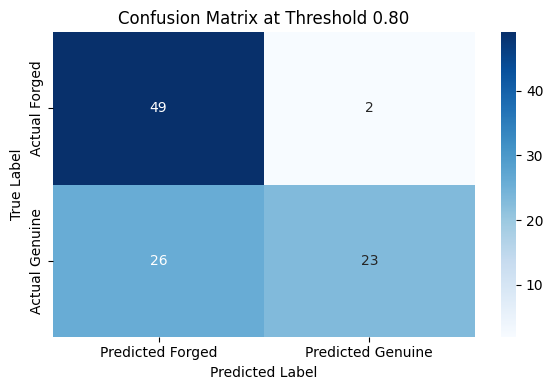

In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already loaded with columns: image1, image2, label
# For example:
# df = pd.read_csv("your_data.csv")

# Apply the signature comparison function
def get_basename(file_path):
    return os.path.basename(file_path)
    
def get_score(row):
    result = compare_boundary_signatures(row['image1'], row['image2'])  # returns dict
    print(f"{get_basename(row['image1'])}---{get_basename(row['image2'])}--{result['final_score']}")
    return result['final_score']  # extract final_score directly

data_df['score'] = data_df.apply(get_score, axis=1)

# Apply threshold to determine predicted label
threshold = 0.80
data_df['predicted'] = data_df['score'].apply(lambda x: 1 if x >= threshold else 0)

cm = confusion_matrix(data_df['label'], data_df['predicted'], labels=[0, 1])
cm_df = pd.DataFrame(cm, index=['Actual Forged', 'Actual Genuine'],
                        columns=['Predicted Forged', 'Predicted Genuine'])
# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix at Threshold 0.80')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [9]:
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)

FAR = fp / (fp + tn)  # False Acceptance Rate: Forged accepted as Genuine
FRR = fn / (fn + tp)  # False Rejection Rate: Genuine rejected as Forged

print(f"Accuracy: {accuracy:.4f}")
print(f"False Acceptance Rate (FAR): {FAR:.4f}")
print(f"False Rejection Rate (FRR): {FRR:.4f}")


Accuracy: 0.7200
False Acceptance Rate (FAR): 0.0392
False Rejection Rate (FRR): 0.5306


In [10]:
import pandas as pd

# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

# Don't truncate column contents
pd.set_option('display.max_colwidth', None)

# Expand output display width
pd.set_option('display.width', None)


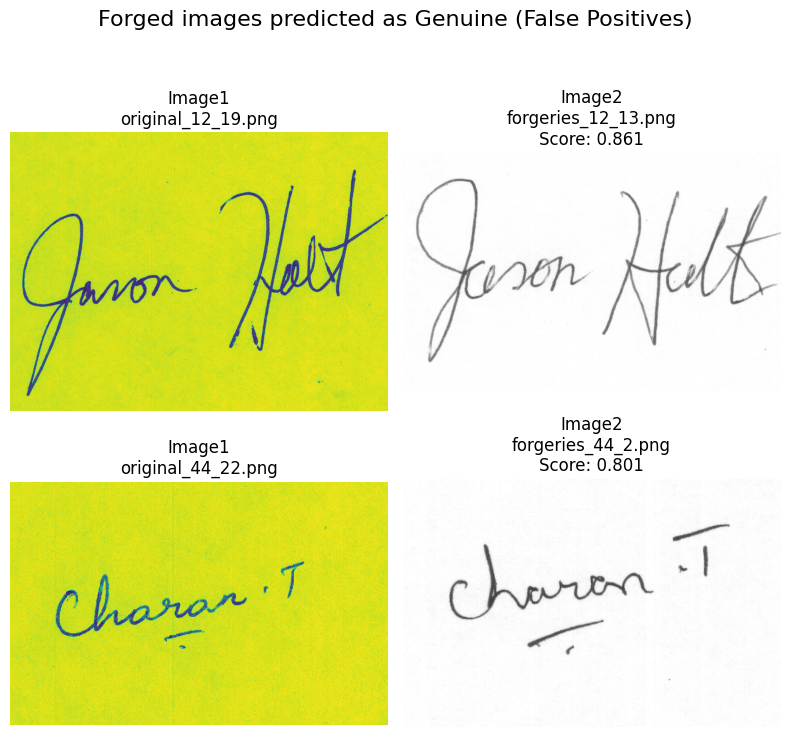

In [8]:
import matplotlib.image as mpimg

# Filter for forged images predicted as genuine (False Negative)
# Assuming label=0 is Forged, predicted=1 is Genuine => FN is forged predicted as genuine
fn_df = data_df[(data_df['label'] == 0) & (data_df['predicted'] == 1)]

# Plot a few examples (max 5 to keep it manageable)
num_to_show = min(5, len(fn_df))

plt.figure(figsize=(8, num_to_show * 4))
for i, (_, row) in enumerate(fn_df.head(num_to_show).iterrows()):
    # Load images
    img1 = mpimg.imread(row['image1'])
    img2 = mpimg.imread(row['image2'])
    
    # Plot side by side
    plt.subplot(num_to_show, 2, 2*i + 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title(f"Image1\n{os.path.basename(row['image1'])}")

    plt.subplot(num_to_show, 2, 2*i + 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title(f"Image2\n{os.path.basename(row['image2'])}\nScore: {row['score']:.3f}")
    
plt.suptitle("Forged images predicted as Genuine (False Positives)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
